## Tasca 5. Exploració de les dades

- [Exercici 1](#Exercici1)  
Descarrega el data set Airlines Delay: Airline on-time statistics and delay causes i carrega’l a un pandas Dataframe. Explora les dades que conté, i queda’t únicament amb les columnes que consideris rellevants.


- [Exercici 2](#Exercici2)  
Fes un informe complet del data set:.
Resumeix estadísticament les columnes d’interès
    - Troba quantes dades faltants hi ha per columna
    - Crea columnes noves (velocitat mitjana del vol, si ha arribat tard o no...)
    - Taula de les aerolínies amb més endarreriments acumulats
    - Quins són els vols més llargs? I els més endarrerits?
    - Etc.


- [Exercici 3](#Exercici3)  
Exporta el data set net i amb les noves columnes a Excel.

<a id='Exercici1'></a>
## Exercici 1

Descarrega el data set [Airlines Delay: Airline on-time statistics and delay causes](https://www.kaggle.com/giovamata/airlinedelaycauses) i carrega’l a un pandas Dataframe. Explora les dades que conté, i queda’t únicament amb les columnes que consideris rellevants.

In [1]:
# importem llibreries

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import time

import os

import warnings

warnings.simplefilter('ignore')

In [2]:
# Constant per convertir de milles a Km
ML_TO_KM = 1.609344

# Constant per definir els minuts en que considerem el vol retrasat
DELAYED_MIN = 0

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

### Carreguem les dades

In [4]:
file = '../data/DelayedFlights.csv'

types = {'DepTime':str, 'CRSDepTime':str, 'ArrTime':str, 'CRSarrTime':str}

parse_dates = [['Year','Month','DayofMonth','DepTime'], ['Year','Month','DayofMonth','ArrTime']]
dfdelays = pd.read_csv(file, dtype=types,  )

# Renombrem la primera columna 
dfdelays.columns = [ 'ind', *dfdelays.columns[1:]]
dfdelays.set_index('ind', inplace=True)

# importem la taula de companyies i les guardem en un diccionari

carrier_file = '../data/Unique_carriers.csv'
carriers = pd.read_csv(carrier_file, index_col=0).to_dict()['Description']

# importem els aeroports. Ho fem directament de la web enllaçada en el dataset de Kaggle

airports = pd.read_csv('http://stat-computing.org/dataexpo/2009/airports.csv', index_col=0).to_dict()['airport']

names = ['Name','City','Country','IATA','ICAO','Lat','Lon','Altitude','Tz','DST','Tz_db','Type','Source']
tzairports = pd.read_csv('../data/airports.dat', index_col=0, names=names).set_index('IATA').to_dict()['Tz_db']

### Observem les Dades 

- **Computerized Reservations Systems (CRS).** 

[Descripció de camps](https://www.transtats.bts.gov/Fields.asp?Table_ID=236)

In [5]:
dfdelays.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
ind,,,,,,,,,,,,,,,,,,,,,
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0000,8.0000,0,N,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0000,10.0000,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0000,17.0000,0,N,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0000,10.0000,0,N,0,2.0000,0.0000,0.0000,0.0000,32.0000
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,4.0000,10.0000,0,N,0,NaN,NaN,NaN,NaN,NaN


### Descripció dels camps
- **ind**: Index 
- **Year, Month, DayofMonth, DayOfWeek**: Columnes amb l'any, mes, dia i dia de la setmana, com a **int**
- **DepTime**: Departure Time. Hora de sortida. En el csv guardat com a **float** amb un decimal  
- **CRSDepTime**: Computerized Reservations Systems Departure Time. Hora teòrica de sortida. Guardat com un **int**. 
- **ArrTime**: Arrival Time. Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers. **float
- **CRSArrTime**: CRS Arrival Time (local time: hhmm)
- **UniqueCarrier**: Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.
- **FlightNum**: Número de vol
- **TailNum**: Número de cua. Número de l'avió
- **ActualElapsedTime**: Temps en minuts. Es una suma de _AirTime_, _TaxiIn_ i _TaxiOut_
- **CRSElapsedTime**: CRS Elapsed Time of Flight, in Minutes
- **AirTime**: Flight Time, in *Minutes*. Temps de vol **float**
- **ArrDelay**: Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.
- **DepDelay**: Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.
- **Origin**: Aeroport d'origen.
- **Dest**: Aeroport de destí.
- **Distance**: Distance between airports (miles). 
- **TaxiIn**: Taxi In Time, in Minutes
- **TaxiOut**: Taxi Out Time, in Minutes
#### Cancel·lacions  
- **Cancelled**: Cancelled Flight Indicator (1=Yes)
- **CancellationCode**: Specifies The Reason For Cancellation:
    - A	Carrier
    - B	Weather
    - C	National Air System
    - D	Security
- **Diverted**:  Diverted Flight Indicator (1=Yes)  
#### Causes dels retràs:
- **CarrierDelay**: Carrier Delay, in Minutes
- **WeatherDelay**: Weather Delay, in Minutes
- **NASDelay**: National Air System Delay, in Minutes
- **SecurityDelay**: Security Delay, in Minutes
- **LateAircraftDelay**: Late Aircraft Delay, in Minutes

### Informació del DataFrame dfdelays

#### info() 
Número de Files, Columnes i nulls

In [6]:
dfdelays.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936758 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Year               1936758 non-null  int64  
 1   Month              1936758 non-null  int64  
 2   DayofMonth         1936758 non-null  int64  
 3   DayOfWeek          1936758 non-null  int64  
 4   DepTime            1936758 non-null  object 
 5   CRSDepTime         1936758 non-null  object 
 6   ArrTime            1929648 non-null  object 
 7   CRSArrTime         1936758 non-null  int64  
 8   UniqueCarrier      1936758 non-null  object 
 9   FlightNum          1936758 non-null  int64  
 10  TailNum            1936753 non-null  object 
 11  ActualElapsedTime  1928371 non-null  float64
 12  CRSElapsedTime     1936560 non-null  float64
 13  AirTime            1928371 non-null  float64
 14  ArrDelay           1928371 non-null  float64
 15  DepDelay           1936758 non-n

In [7]:
print(f"Hi ha {dfdelays.shape[0]} registres.")
print(f'Hi ha {dfdelays.shape[1]} camps per cada registre')

Hi ha 1936758 registres.
Hi ha 29 camps per cada registre


#### describe()

In [8]:
dfdelays.describe()

,Year,Month,DayofMonth,DayOfWeek,CRSArrTime,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,1936758.0000,1936758.0000,1936758.0000,1936758.0000,1936758.0000,1936758.0000,1928371.0000,1936560.0000,1928371.0000,1928371.0000,...,1936758.0000,1929648.0000,1936303.0000,1936758.0000,1936758.0000,1247488.0000,1247488.0000,1247488.0000,1247488.0000,1247488.0000
mean,2008.0000,6.1111,15.7535,3.9848,1634.2246,2184.2632,133.3059,134.3027,108.2771,42.1999,...,765.6862,6.8130,18.2322,0.0003,0.0040,19.1794,3.7036,15.0216,0.0901,25.2965
std,0.0000,3.4825,8.7763,1.9960,464.6347,1944.7023,72.0601,71.3414,68.6426,56.7847,...,574.4797,5.2736,14.3385,0.0181,0.0631,43.5462,21.4929,33.8331,2.0227,42.0549
min,2008.0000,1.0000,1.0000,1.0000,0.0000,1.0000,14.0000,-25.0000,0.0000,-109.0000,...,11.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,2008.0000,3.0000,8.0000,2.0000,1325.0000,610.0000,80.0000,82.0000,58.0000,9.0000,...,338.0000,4.0000,10.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,2008.0000,6.0000,16.0000,4.0000,1705.0000,1543.0000,116.0000,116.0000,90.0000,24.0000,...,606.0000,6.0000,14.0000,0.0000,0.0000,2.0000,0.0000,2.0000,0.0000,8.0000
75%,2008.0000,9.0000,23.0000,6.0000,2014.0000,3422.0000,165.0000,165.0000,137.0000,56.0000,...,998.0000,8.0000,21.0000,0.0000,0.0000,21.0000,0.0000,15.0000,0.0000,33.0000
max,2008.0000,12.0000,31.0000,7.0000,2400.0000,9742.0000,1114.0000,660.0000,1091.0000,2461.0000,...,4962.0000,240.0000,422.0000,1.0000,1.0000,2436.0000,1352.0000,1357.0000,392.0000,1316.0000


#### Camps que tenen valors NaN. 

In [9]:
dfdelays.isna().sum()[dfdelays.isna().sum() > 0]

ArrTime                7110
TailNum                   5
ActualElapsedTime      8387
CRSElapsedTime          198
AirTime                8387
ArrDelay               8387
TaxiIn                 7110
TaxiOut                 455
CarrierDelay         689270
WeatherDelay         689270
NASDelay             689270
SecurityDelay        689270
LateAircraftDelay    689270
dtype: int64

>Comentaris: 
>- Hi ha **8387** vols sense ActualElapsedTime, AirTime, ArrDelay. Observem que són els mateixos vols a la següent cel·la, així com també els **7110** sense valor a l'ArrTime, TaxiIn i els 455 de TaxiOut, els 198 de CRSElapsedTime i un parell dels TailNum  
>- Hi ha **689270** registres sense dades sobre els minuts associats als retrasos (probablement perquè no tenen retrasos). De totes formes, els emplenarem amb 0 minuts.

##### Comprovem aquests camps a partir de l'ActualElapsedTime

In [10]:
act_elapsed_nans = dfdelays[dfdelays.ActualElapsedTime.isna()].isna()
act_elapsed_nans.sum()[act_elapsed_nans.sum() >0]

ArrTime              7110
TailNum                 2
ActualElapsedTime    8387
CRSElapsedTime        198
AirTime              8387
ArrDelay             8387
TaxiIn               7110
TaxiOut               455
CarrierDelay         8387
WeatherDelay         8387
NASDelay             8387
SecurityDelay        8387
LateAircraftDelay    8387
dtype: int64

##### Vols Cancel·lats o Desviats.

In [11]:
print(f'Hi ha {dfdelays.Cancelled.sum()} vols cancel·lats')
print(f'Hi ha {dfdelays.Diverted.sum()} vols desviats')

Hi ha 633 vols cancel·lats
Hi ha 7754 vols desviats


In [12]:
dfdelays[(dfdelays.Cancelled == 1) & (dfdelays.Diverted == 1)]
# No hi ha vols desviats i cancel·lats a la vegada

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
ind,,,,,,,,,,,,,,,,,,,,,


In [13]:
dfdelays[['Diverted','Cancelled']].sum().sum() == dfdelays[dfdelays.ActualElapsedTime.isna()][['Diverted','Cancelled']].sum().sum()

True

> Observem que tots els NaNs a ActualElapsedTime son per vols Cancel·lats o Desviats

#### Assignem 0.0 als camps Null sobre causes de retràs

In [14]:
cols_retras = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
dfdelays[cols_retras] = dfdelays[cols_retras].fillna(value=0.0)

### Decidim quins camps escollim.

In [15]:
mask = (dfdelays.Cancelled == 0) & (dfdelays.Diverted==0)
(dfdelays[mask].AirTime + dfdelays[mask].TaxiIn + dfdelays[mask].TaxiOut - dfdelays[mask].ActualElapsedTime).value_counts()

0.0000    1928371
dtype: int64

Ara mateix:
- no analitzarem les causes dels retrasos i, per això, descartarem els camps associats 
- descartem també els Números de vols, així com el Número de Cua. 
- eliminarem el DayOfWeek 
- Eliminarem els AirTime, TaxiIn, TaxiOut i ens quedarem només amb l'ActualElapsedTime. a la cel·la anterior veiem que sumen el mateix

Posteriorment, després de crear camps addicionals, eliminarem altres columnes


In [16]:
col_descartades = ['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay','CancellationCode', 
                   'FlightNum','TailNum', 'AirTime','TaxiIn','TaxiOut']

# dfdelays.drop(columns=col_descartades, inplace=True)

In [17]:
dfdelays.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
ind,,,,,,,,,,,,,,,,,,,,,
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0000,8.0000,0,N,0,0.0000,0.0000,0.0000,0.0000,0.0000
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0000,10.0000,0,N,0,0.0000,0.0000,0.0000,0.0000,0.0000
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0000,17.0000,0,N,0,0.0000,0.0000,0.0000,0.0000,0.0000
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0000,10.0000,0,N,0,2.0000,0.0000,0.0000,0.0000,32.0000
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,4.0000,10.0000,0,N,0,0.0000,0.0000,0.0000,0.0000,0.0000


<a id='Exercici2'></a>

## Exercici 2

Fes un informe complet del data set:.

Resumeix estadísticament les columnes d’interès
Troba quantes dades faltants hi ha per columna
Crea columnes noves (velocitat mitjana del vol, si ha arribat tard o no...)
Taula de les aerolínies amb més endarreriments acumulats
Quins són els vols més llargs? I els més endarrerits?
Etc.

#### Resum Columnes d'interès

In [18]:
columnes_interes = ['ArrTime','CRSArrTime','ActualElapsedTime','CRSElapsedTime','ArrDelay','DepDelay','Distance']

In [19]:
dfdelays[mask][columnes_interes].describe()

,CRSArrTime,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Distance
count,1928371.0000,1928371.0000,1928371.0000,1928371.0000,1928371.0000,1928371.0000
mean,1634.1962,133.3059,134.1977,42.1999,43.0917,764.9486
std,464.6284,72.0601,71.2334,56.7847,53.2660,573.8858
min,0.0000,14.0000,-21.0000,-109.0000,6.0000,11.0000
25%,1325.0000,80.0000,82.0000,9.0000,12.0000,338.0000
50%,1705.0000,116.0000,116.0000,24.0000,24.0000,606.0000
75%,2014.0000,165.0000,165.0000,56.0000,53.0000,997.0000
max,2359.0000,1114.0000,660.0000,2461.0000,2467.0000,4962.0000


In [20]:
dfdelays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936758 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            object 
 5   CRSDepTime         object 
 6   ArrTime            object 
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

### Noves Columnes

#### noms dels aeroports, zona horària i nom de les companyies

In [21]:
col_descartades = []

dfdelays['carrier_name'] = dfdelays.UniqueCarrier.map(carriers) 
dfdelays['Name_Origin'] = dfdelays.Origin.map(airports) 
dfdelays['Name_Dest'] = dfdelays.Dest.map(airports) 
dfdelays['TZ_Origin'] = dfdelays.Origin.map(tzairports)
dfdelays['TZ_Dest'] = dfdelays.Dest.map(tzairports)
col_descartades.append('UniqueCarrier') 

> Aquí tenim un petit problema que, de moment, no arreglarem (perquè no ho necessitem), però hem de ser-ne conscients.
> Al assignar el DepTime de 2400.0 a 0.0 poso el vol a l'inici del dia. Tot i això, la resta de dades no es veuran afectades, però aquests vols, entenc, van volar al final del dia -i, per tant, la data seria posterior-

In [22]:
dfdelays['dia_add'] = False
dfdelays.loc[dfdelays.DepTime.astype(float)==2400,'DepTime']['dia_add'] = True
dfdelays.loc[dfdelays.DepTime.astype(float)==2400,'DepTime'] = '0.0'

In [23]:
## No cal, calcularem les arribades a partir de la sortida més el temps de vol
# # Els vols que arriben el dia següent. Hi afegirem un dia a les columnes ArrivalTime creades a partir dels camps originals (int i string)

# dfdelays['dia_add'] = dfdelays.DepTime.astype(float) > (dfdelays.ArrTime.astype(float) +100)
# dfdelays['CRSdia_add'] = dfdelays.CRSDepTime.astype(float) > (dfdelays.CRSArrTime.astype(float) +100)

####  Cancel·lat o desviat i Retrasats
 **no_vol** Creem un camp per marcar els vols cancel·lats o desviats  
 **endarrerit** Assignem un valor de 0 minuts com a endarrerit 

In [24]:
dfdelays['no_vol'] = dfdelays.Cancelled + dfdelays.Diverted

dfdelays['endarrerit'] = dfdelays.ArrDelay > DELAYED_MIN

col_descartades.extend(['Cancelled','Diverted'])

### Outliers de camps escollits

#### CRSElapsedTime -> CRSElapsedTime_c

In [25]:
def replace_outliers(group, val=1.5):
    q25, q50, q75 = group.quantile(.25), group.quantile(.5), group.quantile(.75)
    iqr = q75 - q25
    upb = q50 + val * iqr
    lwb = q50 - val * iqr
    outliers = (group > upb) | (group < lwb)
    group[outliers] = q50
    return group

Com hi ha outliers als camps CRSElapsedTime, aquests els canviem per la mediana del vol origen a destí. 

In [26]:
dfdelays['CRSElapsedTime_c'] = dfdelays.groupby(['Origin','Dest']).CRSElapsedTime.transform(replace_outliers)

In [27]:
# Hi havia un valor de CRSElapsedTime (<0), però comprovem que era un outlier i queda corregit
mask = (dfdelays.CRSElapsedTime<0) & (dfdelays.no_vol == 0)
dfdelays[mask][['CRSElapsedTime','ActualElapsedTime','Origin','Dest','UniqueCarrier','CRSElapsedTime_c']]

,CRSElapsedTime,ActualElapsedTime,Origin,Dest,UniqueCarrier,CRSElapsedTime_c
ind,,,,,,
1358057,-21.0000,31.0000,MRY,SFO,OO,39.0000


#### Airtime=0 
Tot i que hi ha valor a l'ActualElapsedTime, sembla difícil que aquests valors siguin reals. 
Els canviarem per la mediana dels vols entre aquests aeroports i companyies

In [28]:
dfdelays[dfdelays.AirTime == 0][['AirTime','Distance','Origin','Dest','TaxiIn','TaxiOut','ActualElapsedTime','CRSElapsedTime','UniqueCarrier','DepDelay','ArrDelay']]

,AirTime,Distance,Origin,Dest,TaxiIn,TaxiOut,ActualElapsedTime,CRSElapsedTime,UniqueCarrier,DepDelay,ArrDelay
ind,,,,,,,,,,,
175935,0.0000,269,SGU,SLC,96.0000,2.0000,98.0000,78.0000,OO,98.0000,118.0000
177448,0.0000,175,TWF,SLC,90.0000,3.0000,93.0000,56.0000,OO,67.0000,104.0000
782963,0.0000,1013,ASE,ORD,8.0000,162.0000,170.0000,164.0000,OO,177.0000,183.0000
1277190,0.0000,690,MSY,MCI,4.0000,140.0000,144.0000,130.0000,XE,10.0000,24.0000
1374982,0.0000,1013,ASE,ORD,12.0000,141.0000,153.0000,164.0000,OO,108.0000,97.0000
2588940,0.0000,109,LAX,SAN,52.0000,2.0000,54.0000,52.0000,OO,10.0000,12.0000
2597845,0.0000,109,SAN,LAX,25.0000,3.0000,28.0000,45.0000,OO,15.0000,-2.0000


In [29]:
def replace_zeros(group):
    zeros = group == 0
    group[zeros] = group.median()
    return group

dfdelays['AirTime'] = dfdelays.groupby(['Origin','Dest','UniqueCarrier']).AirTime.transform(replace_zeros)

In [30]:
dfdelays['ActualElapsedTime_c'] = dfdelays[['AirTime','TaxiIn','TaxiOut']].sum(axis=1)

In [31]:
dfdelays[['AirTime','Distance','Origin','Dest','TaxiIn','TaxiOut','ActualElapsedTime','ActualElapsedTime_c','CRSElapsedTime','UniqueCarrier','DepDelay','ArrDelay']].head()

,AirTime,Distance,Origin,Dest,TaxiIn,TaxiOut,ActualElapsedTime,ActualElapsedTime_c,CRSElapsedTime,UniqueCarrier,DepDelay,ArrDelay
ind,,,,,,,,,,,,
0,116.0000,810,IAD,TPA,4.0000,8.0000,128.0000,128.0000,150.0000,WN,8.0000,-14.0000
1,113.0000,810,IAD,TPA,5.0000,10.0000,128.0000,128.0000,145.0000,WN,19.0000,2.0000
2,76.0000,515,IND,BWI,3.0000,17.0000,96.0000,96.0000,90.0000,WN,8.0000,14.0000
4,77.0000,515,IND,BWI,3.0000,10.0000,90.0000,90.0000,90.0000,WN,34.0000,34.0000
5,87.0000,688,IND,JAX,4.0000,10.0000,101.0000,101.0000,115.0000,WN,25.0000,11.0000


Convertim les columnes de **DepTime** i **CRSDepTime** (hora i minut) i Any, Mes, Dia a un datetime

In [32]:

dfdelays['DepartureTime'] = dfdelays.apply(lambda x: datetime(int(x.Year), 
                                       int(x.Month), 
                                       int(x.DayofMonth), 
                                       int(x.DepTime.split('.')[0].zfill(4)[:-2]), 
                                       int(x.DepTime.split('.')[0].zfill(4)[-2:])), axis=1)

dfdelays['CRSDepartureTime'] = dfdelays.apply(lambda x: datetime(int(x.Year),
                                       int(x.Month), 
                                       int(x.DayofMonth), 
                                       int(x.CRSDepTime.zfill(4)[:-2]), 
                                       int(x.CRSDepTime.zfill(4)[-2:])), axis=1)

col_descartades.extend(['ind','Year','Month','DayofMonth','DayOfWeek','DepTime','CRSDepTime'])

In [33]:
# Creem els Nous ArrivalTimes amb els camps corregits
dfdelays['ArrivalTime'] = dfdelays.DepartureTime + pd.to_timedelta(dfdelays.ActualElapsedTime_c,unit='m')
dfdelays['CRSArrivalTime'] = dfdelays.CRSDepartureTime + pd.to_timedelta(dfdelays.CRSElapsedTime_c,unit='m')



#### Numero de vols per dia i Aeroport

In [34]:
dfdelays.groupby(['Origin',pd.Grouper(key='DepartureTime',freq='d')]).agg({'DepDelay':'count','endarrerit':'sum'})

DepDelay  endarrerit
Origin DepartureTime                      
ABE    2008-01-01            7           7
       2008-01-02            4           4
       2008-01-03            8           7
       2008-01-04            5           4
       2008-01-05            2           2
...                        ...         ...
YUM    2008-12-27            1           1
       2008-12-28            3           3
       2008-12-29            1           1
       2008-12-30            1           1
       2008-12-31            3           3

[80005 rows x 2 columns]

In [35]:
dfdelays.groupby(['Dest', pd.Grouper(key='ArrivalTime', freq='d')]).agg({'ArrDelay':'count','endarrerit':'sum'})

ArrDelay  endarrerit
Dest ArrivalTime                      
ABE  2008-01-01         10          10
     2008-01-02          9           9
     2008-01-03         10          10
     2008-01-04          4           4
     2008-01-05          4           4
...                    ...         ...
YUM  2008-12-27          1           1
     2008-12-28          2           2
     2008-12-29          1           1
     2008-12-30          1           1
     2008-12-31          3           3

[84829 rows x 2 columns]

In [36]:
# l'ActualElapsedTime no l'hauriem de modificar, ja que inclou els TaxiIn i TaxiOut que poden provocar outliers per retrasos
# dfdelays['ActualElapsedTime_c'] = dfdelays.groupby(['Origin','Dest']).ActualElapsedTime.transform(replace_outliers)
# comprovem la distribució amb els AirTime/Distance

## Tenim AirTimes a 0 --> No sembla possible

((dfdelays.Distance*ML_TO_KM)/(dfdelays.AirTime/60)).describe()

count   1928371.0000
mean        638.8330
std         156.9347
min          34.2635
25%         566.2709
50%         649.8857
75%         721.2245
max       89994.5165
dtype: float64

In [37]:
dfdelays[['ArrDelay','DepDelay', 'AirTime','TaxiIn','TaxiOut','Distance','Origin']].describe()

,ArrDelay,DepDelay,AirTime,TaxiIn,TaxiOut,Distance
count,1928371.0000,1936758.0000,1928371.0000,1929648.0000,1936303.0000,1936758.0000
mean,42.1999,43.1852,108.2774,6.8130,18.2322,765.6862
std,56.7847,53.4025,68.6424,5.2736,14.3385,574.4797
min,-109.0000,6.0000,1.0000,0.0000,0.0000,11.0000
25%,9.0000,12.0000,58.0000,4.0000,10.0000,338.0000
50%,24.0000,24.0000,90.0000,6.0000,14.0000,606.0000
75%,56.0000,53.0000,137.0000,8.0000,21.0000,998.0000
max,2461.0000,2467.0000,1091.0000,240.0000,422.0000,4962.0000


In [38]:
view_cols = ['TaxiIn','TaxiOut','AirTime','Distance','Origin','Dest','CRSDepartureTime','DepartureTime','CRSElapsedTime','ArrDelay','DepDelay', 'UniqueCarrier']
dfdelays[dfdelays.AirTime < 10][view_cols]

,TaxiIn,TaxiOut,AirTime,Distance,Origin,Dest,CRSDepartureTime,DepartureTime,CRSElapsedTime,ArrDelay,DepDelay,UniqueCarrier
ind,,,,,,,,,,,,
101625,11.0000,47.0000,3.0000,337,SFO,LAX,2008-01-05 19:50:00,2008-01-05 22:45:00,78.0000,158.0000,175.0000,XE
146122,14.0000,14.0000,7.0000,84,ORD,SBN,2008-01-24 11:55:00,2008-01-24 12:12:00,48.0000,4.0000,17.0000,YV
172574,5.0000,49.0000,1.0000,150,SLC,PIH,2008-01-03 21:03:00,2008-01-03 21:29:00,57.0000,24.0000,26.0000,OO
175911,5.0000,43.0000,4.0000,150,SLC,PIH,2008-01-05 21:03:00,2008-01-05 21:28:00,57.0000,20.0000,25.0000,OO
175925,2.0000,63.0000,2.0000,223,SLC,SUN,2008-01-05 17:15:00,2008-01-05 18:42:00,69.0000,85.0000,87.0000,OO
...,...,...,...,...,...,...,...,...,...,...,...,...
6895253,10.0000,10.0000,6.0000,70,CVG,LEX,2008-12-19 21:05:00,2008-12-19 21:34:00,37.0000,18.0000,29.0000,9E
6946404,4.0000,5.0000,9.0000,31,WRG,PSG,2008-12-09 10:07:00,2008-12-09 10:17:00,26.0000,2.0000,10.0000,AS
6950263,6.0000,12.0000,8.0000,31,WRG,PSG,2008-12-19 10:07:00,2008-12-19 10:24:00,26.0000,17.0000,17.0000,AS


In [39]:
mask = (dfdelays.AirTime < 60) & (dfdelays.Origin == 'SFO') & (dfdelays.Dest=='LAX')
dfdelays[mask][view_cols].AirTime.median()

54.0

In [40]:
tempdf = dfdelays.groupby(['Origin',pd.Grouper(key='DepartureTime',freq='d')]).DepDelay.mean().reset_index()


tempdf.pivot(index='Origin',columns='DepartureTime', values='DepDelay').mean(axis=1).describe()

count   303.0000
mean     45.6593
std      11.4012
min      11.0000
25%      38.0311
50%      44.9479
75%      51.2835
max     118.0303
dtype: float64

#### Descartem les files que no ens interessen

Per exemple, les files dels vols cancel·lats o desviats (*no_vol = 1*)

In [41]:
dfdelays.drop(dfdelays.loc[dfdelays.no_vol>0].index,axis=0, inplace=True)

### Comprovem els ElapsedTime i les hores d'arribada

In [42]:
dfdelays.loc[dfdelays.DepTime.astype(float) > dfdelays.ArrTime.astype(float)].sort_values('DayofMonth')

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TZ_Dest,dia_add,no_vol,endarrerit,CRSElapsedTime_c,ActualElapsedTime_c,DepartureTime,CRSDepartureTime,ArrivalTime,CRSArrivalTime
ind,,,,,,,,,,,,,,,,,,,,,
3294931,2008,6,1,7,2132.0,2125,49.0,55,WN,3167,...,America/New_York,False,0,False,150.0000,137.0000,2008-06-01 21:32:00,2008-06-01 21:25:00,2008-06-01 23:49:00,2008-06-01 23:55:00
353994,2008,1,1,2,2317.0,2255,45.0,36,FL,462,...,America/New_York,False,0,True,101.0000,88.0000,2008-01-01 23:17:00,2008-01-01 22:55:00,2008-01-02 00:45:00,2008-01-02 00:36:00
3117973,2008,6,1,7,2317.0,1930,128.0,2159,XE,2753,...,America/Chicago,False,0,True,209.0000,191.0000,2008-06-01 23:17:00,2008-06-01 19:30:00,2008-06-02 02:28:00,2008-06-01 22:59:00
3118228,2008,6,1,7,2058.0,2045,5.0,2348,XE,2820,...,America/New_York,False,0,True,123.0000,127.0000,2008-06-01 20:58:00,2008-06-01 20:45:00,2008-06-01 23:05:00,2008-06-01 22:48:00
3119494,2008,6,1,7,2143.0,2030,5.0,2252,XE,2675,...,America/New_York,False,0,True,142.0000,142.0000,2008-06-01 21:43:00,2008-06-01 20:30:00,2008-06-02 00:05:00,2008-06-01 22:52:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742226,2008,3,31,1,2201.0,2125,604.0,600,B6,638,...,America/New_York,False,0,True,335.0000,303.0000,2008-03-31 22:01:00,2008-03-31 21:25:00,2008-04-01 03:04:00,2008-04-01 03:00:00
1742224,2008,3,31,1,2227.0,2220,630.0,622,B6,498,...,America/New_York,False,0,True,302.0000,303.0000,2008-03-31 22:27:00,2008-03-31 22:20:00,2008-04-01 03:30:00,2008-04-01 03:22:00
4060339,2008,7,31,4,2357.0,2252,32.0,2333,NW,767,...,America/Chicago,False,0,True,116.0000,95.0000,2008-07-31 23:57:00,2008-07-31 22:52:00,2008-08-01 01:32:00,2008-08-01 00:48:00


In [43]:
dfdelays.sort_values('CRSElapsedTime')['CRSElapsedTime']

ind
1358057   -21.0000
2268727     1.0000
5688417     2.0000
2484976     8.0000
3701794     9.0000
            ...   
1134314   660.0000
1156765   660.0000
1742574   660.0000
1742556   660.0000
564683    660.0000
Name: CRSElapsedTime, Length: 1928371, dtype: float64

In [44]:
dfdelays.sort_values('ActualElapsedTime')['ActualElapsedTime']

ind
4765934     14.0000
1116584     15.0000
2927416     15.0000
4150358     15.0000
4779599     15.0000
             ...   
4811552    750.0000
4614554    750.0000
3922427    776.0000
6980183    790.0000
5180146   1114.0000
Name: ActualElapsedTime, Length: 1928371, dtype: float64

In [45]:
(((dfdelays.DepartureTime - dfdelays.ArrivalTime).dt.total_seconds()/60) > 0).sum()

0

In [46]:
(((dfdelays.CRSDepartureTime - dfdelays.CRSArrivalTime).dt.total_seconds()/60) > -10).sum()

3

<AxesSubplot:>

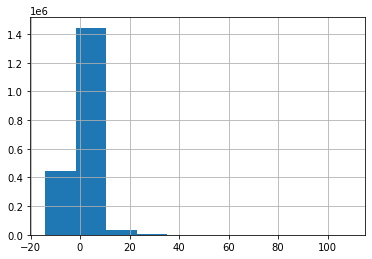

In [47]:
(dfdelays[['CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']].sum(axis=1) - dfdelays.ArrDelay).hist()

<AxesSubplot:>

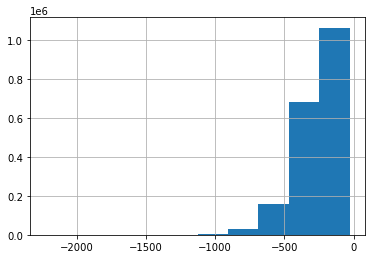

In [48]:
(((dfdelays.DepartureTime - dfdelays.ArrivalTime).dt.total_seconds()/60) - dfdelays.ActualElapsedTime).hist()

<AxesSubplot:>

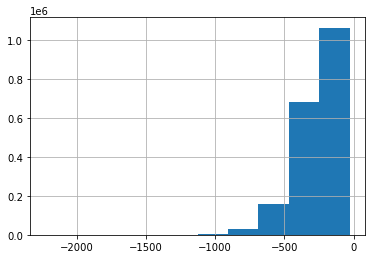

In [49]:
(((dfdelays.DepartureTime - dfdelays.ArrivalTime).dt.total_seconds()/60) - dfdelays.ActualElapsedTime).hist()

#### Descartem les columnes que no ens interesen

In [50]:
# dfdelays.drop(columns=col_descartades, inplace=True)

In [51]:
dfdelays.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TZ_Dest,dia_add,no_vol,endarrerit,CRSElapsedTime_c,ActualElapsedTime_c,DepartureTime,CRSDepartureTime,ArrivalTime,CRSArrivalTime
ind,,,,,,,,,,,,,,,,,,,,,
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,America/New_York,False,0,False,140.0000,128.0000,2008-01-03 20:03:00,2008-01-03 19:55:00,2008-01-03 22:11:00,2008-01-03 22:15:00
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,America/New_York,False,0,True,145.0000,128.0000,2008-01-03 07:54:00,2008-01-03 07:35:00,2008-01-03 10:02:00,2008-01-03 10:00:00
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,America/New_York,False,0,True,90.0000,96.0000,2008-01-03 06:28:00,2008-01-03 06:20:00,2008-01-03 08:04:00,2008-01-03 07:50:00
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,America/New_York,False,0,True,90.0000,90.0000,2008-01-03 18:29:00,2008-01-03 17:55:00,2008-01-03 19:59:00,2008-01-03 19:25:00
5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,...,America/New_York,False,0,True,115.0000,101.0000,2008-01-03 19:40:00,2008-01-03 19:15:00,2008-01-03 21:21:00,2008-01-03 21:10:00


In [52]:
%whos DataFrame

Variable           Type         Data/Info
-----------------------------------------
act_elapsed_nans   DataFrame              Year  Month  Da<...>n[8387 rows x 29 columns]
dfdelays           DataFrame             Year  Month  Day<...>928371 rows x 43 columns]
tempdf             DataFrame          Origin DepartureTim<...>n[80005 rows x 3 columns]


In [53]:
col_descartades

['UniqueCarrier',
 'Cancelled',
 'Diverted',
 'ind',
 'Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime']

### velocitat mitjana de vol

tenim que controlar que les dades siguin adequades. Per exemple, que passa si són NaNs, o baixes?
Exemple: un vol desviat, a l'índex 317163
```python
dfdelays.iloc[317163]
```

In [54]:
# mask es un filtre per escollir els vols no cancel·lats

mask = dfdelays.no_vol == 0
(dfdelays[mask].Distance / (dfdelays[mask].CRSElapsedTime)).sort_values(ascending=False)

ind
2268727   764.0000
5688417   123.5000
527950     43.1190
4986919    21.6167
3910429    13.7083
            ...   
4989833     0.5000
151660      0.4000
4392215     0.1833
2547298     0.1833
1358057    -3.6667
Length: 1928371, dtype: float64

In [55]:
mask = dfdelays.no_vol == 0
(dfdelays[mask].Distance / (dfdelays[mask].ActualElapsedTime.astype(int) /60)).sort_values(ascending=False)

ind
3698229   1662.8571
3763347   1242.0000
161904    1000.0000
1047958    980.0000
78681      972.0000
             ...   
1586287     16.2097
6836498     15.5212
2547298     13.7500
4989833     13.5338
4392215     11.0000
Length: 1928371, dtype: float64

Veiem que hi ha dades que no semblen molt raonables, amb velocitats molt altes o molt baixes.
Analitzem-ne alguns casos per comprovar el perquè

Exemples de casos amb dades extranyes. 
Alternatives amb aquests casos:
- esborrar-los (opció fàcil, però s'ha de considerar el número i si poden ser importants per la tasca a considerar)
- corregir-los manualment (possible fer-ho si son molt pocs)
- imputar un valor en base a diversos criteris automàticament

In [56]:
dfdelays.iloc[693851]

Year                                     2008
Month                                       4
DayofMonth                                 26
DayOfWeek                                   6
DepTime                                1358.0
CRSDepTime                               1330
ArrTime                                1702.0
CRSArrTime                               1625
UniqueCarrier                              AA
FlightNum                                 809
TailNum                                N5CNAA
ActualElapsedTime                    184.0000
CRSElapsedTime                       175.0000
AirTime                              170.0000
ArrDelay                              37.0000
DepDelay                              28.0000
Origin                                    MIA
Dest                                      LGA
Distance                                 1097
TaxiIn                                 5.0000
TaxiOut                                9.0000
Cancelled                         

Vols que tenen temps teòric de vol extranys, ```<10``` minuts

In [57]:
dfdelays[mask][dfdelays.CRSElapsedTime < 10]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TZ_Dest,dia_add,no_vol,endarrerit,CRSElapsedTime_c,ActualElapsedTime_c,DepartureTime,CRSDepartureTime,ArrivalTime,CRSArrivalTime
ind,,,,,,,,,,,,,,,,,,,,,
1358057,2008,3,8,6,1839.0,1756,1910.0,1735,OO,5428,...,America/Los_Angeles,False,0,True,39.0000,31.0000,2008-03-08 18:39:00,2008-03-08 17:56:00,2008-03-08 19:10:00,2008-03-08 18:35:00
2268727,2008,4,27,7,2203.0,1945,50.0,2046,AA,434,...,America/New_York,False,0,True,130.0000,107.0000,2008-04-27 22:03:00,2008-04-27 19:45:00,2008-04-27 23:50:00,2008-04-27 21:55:00
2484976,2008,5,15,4,941.0,921,1008.0,929,XE,16,...,America/Los_Angeles,False,0,True,8.0000,27.0000,2008-05-15 09:41:00,2008-05-15 09:21:00,2008-05-15 10:08:00,2008-05-15 09:29:00
3701794,2008,7,8,2,1740.0,1655,1814.0,1704,XE,104,...,America/Denver,False,0,True,9.0000,34.0000,2008-07-08 17:40:00,2008-07-08 16:55:00,2008-07-08 18:14:00,2008-07-08 17:04:00
3702095,2008,7,14,1,1331.0,1322,1449.0,1331,XE,117,...,America/Denver,False,0,True,9.0000,78.0000,2008-07-14 13:31:00,2008-07-14 13:22:00,2008-07-14 14:49:00,2008-07-14 13:31:00
5688417,2008,10,20,1,1240.0,1225,1252.0,1127,EV,5188,...,America/Chicago,False,0,True,83.0000,72.0000,2008-10-20 12:40:00,2008-10-20 12:25:00,2008-10-20 13:52:00,2008-10-20 13:48:00


### Aerolinies amb més endarreriments?

In [58]:
# No considerem els vols cancel·lats o desviats
filtre = (dfdelays.no_vol == 0)

agrupat_carrier = dfdelays[filtre].groupby(['carrier_name']).agg({'ArrDelay':['sum','count'], 'endarrerit':'sum', 'Distance':'sum'})

agrupat_carrier.columns = ['_'.join(col).strip('_') for col in agrupat_carrier.columns.values]
# group.droplevel(0, axis=1)
agrupat_carrier.reset_index(inplace=True)
agrupat_carrier.sort_values(('endarrerit_sum'),ascending=False).head(10)


,carrier_name,ArrDelay_sum,ArrDelay_count,endarrerit_sum,Distance_sum
17,Southwest Airlines Co.,11319092.0000,376201,324717,244698861
3,American Airlines Inc.,8889066.0000,190910,172197,206431212
7,Envoy Air,6396704.0000,141223,130647,61146137
19,United Air Lines Inc.,6733013.0000,140904,123989,152029654
16,SkyWest Airlines Inc.,5978936.0000,131780,121942,58023344
5,Delta Air Lines Inc.,4535644.0000,113728,100923,110001518
8,ExpressJet Airlines Inc.,5176042.0000,103147,94313,61741939
4,Continental Air Lines Inc.,4045932.0000,99731,83646,123568066
18,US Airways Inc.,3571867.0000,98007,83262,94668681
9,ExpressJet Airlines LLC,3888131.0000,81762,75170,37730644


In [59]:
dfdelays.groupby(['carrier_name'])['endarrerit'].sum().sort_values(ascending=False).head(10)

carrier_name
Southwest Airlines Co.        324717
American Airlines Inc.        172197
Envoy Air                     130647
United Air Lines Inc.         123989
SkyWest Airlines Inc.         121942
Delta Air Lines Inc.          100923
ExpressJet Airlines Inc.       94313
Continental Air Lines Inc.     83646
US Airways Inc.                83262
ExpressJet Airlines LLC        75170
Name: endarrerit, dtype: int64

### I amb més endarreriments acumulats?

In [60]:
agrupat_carrier.sort_values('ArrDelay_sum', ascending=False)[['carrier_name','ArrDelay_sum']].head(10)

,carrier_name,ArrDelay_sum
17,Southwest Airlines Co.,11319092.0000
3,American Airlines Inc.,8889066.0000
19,United Air Lines Inc.,6733013.0000
7,Envoy Air,6396704.0000
16,SkyWest Airlines Inc.,5978936.0000
8,ExpressJet Airlines Inc.,5176042.0000
5,Delta Air Lines Inc.,4535644.0000
4,Continental Air Lines Inc.,4045932.0000
9,ExpressJet Airlines LLC,3888131.0000
13,Mesa Airlines Inc.,3691461.0000


### amb minuts/distancia feta

In [61]:
agrupat_carrier['m_distancia'] = (agrupat_carrier[('ArrDelay_sum')] / agrupat_carrier[('Distance_sum')])
agrupat_carrier.sort_values('m_distancia',ascending=False)[['carrier_name','m_distancia']].head(10)

,carrier_name,m_distancia
13,Mesa Airlines Inc.,0.1359
7,Envoy Air,0.1046
9,ExpressJet Airlines LLC,0.1030
16,SkyWest Airlines Inc.,0.1030
6,Endeavor Air Inc.,0.1012
15,PSA Airlines Inc.,0.0995
8,ExpressJet Airlines Inc.,0.0838
0,AirTran Airways Corporation,0.0597
14,Northwest Airlines Inc.,0.0533
12,JetBlue Airways,0.0500


### % vols amb retràs

In [62]:
agrupat_carrier['perc_retras'] = (agrupat_carrier['endarrerit_sum'] / agrupat_carrier['ArrDelay_count']) * 100
agrupat_carrier.sort_values('perc_retras', ascending=False)[['carrier_name','perc_retras']].head(10)

,carrier_name,perc_retras
11,Hawaiian Airlines Inc.,96.3464
13,Mesa Airlines Inc.,94.7880
15,PSA Airlines Inc.,93.6152
16,SkyWest Airlines Inc.,92.5345
7,Envoy Air,92.5111
9,ExpressJet Airlines LLC,91.9376
14,Northwest Airlines Inc.,91.8217
0,AirTran Airways Corporation,91.6006
8,ExpressJet Airlines Inc.,91.4355
10,Frontier Airlines Inc.,91.0856


### companyies amb % de vols retrasats més baixos

In [63]:
agrupat_carrier.sort_values('perc_retras', ascending=True)[['carrier_name','perc_retras']].head(10)

,carrier_name,perc_retras
4,Continental Air Lines Inc.,83.8716
18,US Airways Inc.,84.9552
17,Southwest Airlines Co.,86.3148
1,Alaska Airlines Inc.,87.6160
12,JetBlue Airways,87.7142
2,Aloha Airlines Inc.,87.9032
19,United Air Lines Inc.,87.9954
5,Delta Air Lines Inc.,88.7407
3,American Airlines Inc.,90.1980
6,Endeavor Air Inc.,90.9384


### Quins son els vols més llargs?

In [64]:
vols_llargs = dfdelays.groupby(['Origin', 'Name_Origin','Dest','Name_Dest','UniqueCarrier','carrier_name'])['Distance'].first()
vols_llargs = vols_llargs.sort_values( ascending=False).reset_index()

vols_llargs.head(10)


,Origin,Name_Origin,Dest,Name_Dest,UniqueCarrier,carrier_name,Distance
0,EWR,Newark Intl,HNL,Honolulu International,CO,Continental Air Lines Inc.,4962
1,HNL,Honolulu International,EWR,Newark Intl,CO,Continental Air Lines Inc.,4962
2,ATL,William B Hartsfield-Atlanta Intl,HNL,Honolulu International,DL,Delta Air Lines Inc.,4502
3,HNL,Honolulu International,ATL,William B Hartsfield-Atlanta Intl,DL,Delta Air Lines Inc.,4502
4,HNL,Honolulu International,ORD,Chicago O'Hare International,UA,United Air Lines Inc.,4243
5,HNL,Honolulu International,ORD,Chicago O'Hare International,AA,American Airlines Inc.,4243
6,ORD,Chicago O'Hare International,HNL,Honolulu International,UA,United Air Lines Inc.,4243
7,ORD,Chicago O'Hare International,HNL,Honolulu International,AA,American Airlines Inc.,4243
8,KOA,Kona International At Keahole,ORD,Chicago O'Hare International,UA,United Air Lines Inc.,4213
9,ORD,Chicago O'Hare International,OGG,Kahului,UA,United Air Lines Inc.,4184


### Llista dels més endarrerits (top-10)

In [65]:
dfdelays.sort_values(by='ArrDelay', ascending=False).head(10)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TZ_Dest,dia_add,no_vol,endarrerit,CRSElapsedTime_c,ActualElapsedTime_c,DepartureTime,CRSDepartureTime,ArrivalTime,CRSArrivalTime
ind,,,,,,,,,,,,,,,,,,,,,
1018798,2008,2,3,7,1117.0,1820,2256.0,555,NW,808,...,America/Chicago,False,0,True,455.0000,459.0000,2008-02-03 11:17:00,2008-02-03 18:20:00,2008-02-03 18:56:00,2008-02-04 01:55:00
2235378,2008,4,10,4,724.0,1417,858.0,1605,NW,1699,...,America/Chicago,False,0,True,168.0000,154.0000,2008-04-10 07:24:00,2008-04-10 14:17:00,2008-04-10 09:58:00,2008-04-10 17:05:00
2832617,2008,5,6,2,2.0,1530,254.0,1823,NW,1107,...,America/New_York,False,0,True,173.0000,172.0000,2008-05-06 00:02:00,2008-05-06 15:30:00,2008-05-06 02:54:00,2008-05-06 18:23:00
3387883,2008,6,20,5,2140.0,1710,2252.0,1825,MQ,3538,...,America/Chicago,False,0,True,75.0000,72.0000,2008-06-20 21:40:00,2008-06-20 17:10:00,2008-06-20 22:52:00,2008-06-20 18:25:00
6857047,2008,12,19,5,1602.0,1325,1921.0,1546,NW,357,...,America/Chicago,False,0,True,201.0000,259.0000,2008-12-19 16:02:00,2008-12-19 13:25:00,2008-12-19 20:21:00,2008-12-19 16:46:00
5232546,2008,9,1,1,906.0,714,1048.0,825,NW,512,...,America/Chicago,False,0,True,71.0000,102.0000,2008-09-01 09:06:00,2008-09-01 07:14:00,2008-09-01 10:48:00,2008-09-01 08:25:00
2232494,2008,4,27,7,1818.0,1633,1942.0,1800,NW,1472,...,America/Chicago,False,0,True,87.0000,84.0000,2008-04-27 18:18:00,2008-04-27 16:33:00,2008-04-27 19:42:00,2008-04-27 18:00:00
527950,2008,1,5,6,800.0,1045,1452.0,1327,AA,2398,...,America/New_York,False,0,True,245.0000,292.0000,2008-01-05 08:00:00,2008-01-05 10:45:00,2008-01-05 12:52:00,2008-01-05 14:50:00
4061361,2008,7,16,3,820.0,702,1325.0,1215,NW,804,...,America/Chicago,False,0,True,193.0000,185.0000,2008-07-16 08:20:00,2008-07-16 07:02:00,2008-07-16 11:25:00,2008-07-16 10:15:00


#### Altres columnes

In [83]:
# Número de vols que surten i arriben als aeroport de sortida i arribada a la 'mateixa' hora
dfdelays['Dep_hourlyf'] = dfdelays.groupby([pd.Grouper(key='CRSDepartureTime',freq='H'),'Origin']).ArrTime.transform('count')
dfdelays['Arr_hourlyf'] = dfdelays.groupby([pd.Grouper(key='CRSArrivalTime',freq='H'),'Dest']).ArrTime.transform('count')

# Número de vols que surten i arriben als aeroport de sortida i arribada al 'mateix' dia
dfdelays['Dep_dailyf'] = dfdelays.groupby([pd.Grouper(key='CRSDepartureTime',freq='D'),'Origin']).ArrTime.transform('count')
dfdelays['Arr_dailyf'] = dfdelays.groupby([pd.Grouper(key='CRSArrivalTime',freq='D'),'Dest']).ArrTime.transform('count')

In [84]:
dfdelays[['Year','DepartureTime','Origin','Dest','Dep_hourlyf','Arr_hourlyf','Dep_dailyf','Arr_dailyf']].head()

,Year,DepartureTime,Origin,Dest,Dep_hourlyf,Arr_hourlyf,Dep_dailyf,Arr_dailyf
ind,,,,,,,,
0,2008,2008-01-03 20:03:00,IAD,TPA,6,15,95,143
1,2008,2008-01-03 07:54:00,IAD,TPA,9,10,95,143
2,2008,2008-01-03 06:28:00,IND,BWI,2,4,39,166
4,2008,2008-01-03 18:29:00,IND,BWI,3,14,39,166
5,2008,2008-01-03 19:40:00,IND,JAX,2,5,39,51


<a id='Exercici3'></a>

## Exercici 3

#### Exporta el data set net i amb les noves columnes a Excel.

In [88]:
dfdelays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928371 entries, 0 to 7009727
Data columns (total 47 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Year                 int64         
 1   Month                int64         
 2   DayofMonth           int64         
 3   DayOfWeek            int64         
 4   DepTime              object        
 5   CRSDepTime           object        
 6   ArrTime              object        
 7   CRSArrTime           int64         
 8   UniqueCarrier        object        
 9   FlightNum            int64         
 10  TailNum              object        
 11  ActualElapsedTime    float64       
 12  CRSElapsedTime       float64       
 13  AirTime              float64       
 14  ArrDelay             float64       
 15  DepDelay             float64       
 16  Origin               object        
 17  Dest                 object        
 18  Distance             int64         
 19  TaxiIn               

In [89]:

dfdelays.to_csv('../Data/CleanDelayedFlights.csv', index=False)

In [90]:
dfdelays.to_pickle('../Data/CleanDelayedFlights.pickle')

In [69]:
agrupat_carrier.to_csv('../Data/AggDelayedFlights_carrier.csv')

agrupat_airports.to_csv('../Data/AggDelayedFlights_airports.csv')

NameError: name 'agrupat_airports' is not defined

In [ ]:
tempdf.head()

In [ ]:
# df["Year"] = df.DATE.apply(lambda x: x.year)
# df["Month"] = df.DATE.apply(lambda x: x.strftime("%B"))
dfhm = tempdf.pivot_table(index="Origin",columns="DepartureTime",values="DepDelay", aggfunc="sum").fillna(0)
# months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]#
# pt = pt.reindex_axis(months)
sns.heatmap(dfhm, annot=True)